# The main file of the project.

In [67]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import app.var_examination as ve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split


## Background info

The Boston Housing Dataset has been removed from the Scikit-Learn library in December 2022, after decades of its use for teaching purposes. Originally, the dataset comes from a research paper *Hedonic housing prices and the demand for clean air* by D. Harrison and D. Rubinfield, published in 1978. 

The dataset has been removed and its use is now discouraged for several reasons, the main of which is the inclusion of the `B` variable, which is a column whose values are calculated as `B=1000(Bk-063)^2` where `Bk` is, "the proportion of blacks by town." The quadratic formula is motivated by an argument of the authors that race segregation has positive impact on housing prices, 

**The goal of this project is to examine the role of the Bk variable and show the issues with its inclussion in the dataset, as well as show the impact of the variable on standard models that were used to process this data.** 

We state that the inclusion of the variable in this context, and the idea of using race to predict prices without considering it as a tremendous issue, are and always will be unaccpetable.

## Current state

Importing the dataset in the traditional way now throws the following error:

In [68]:
try:
    bostn = datasets.load_boston()
except Exception as e:
    print(e)


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_d

# Obtaining the data "by hand"

The documentation of Scikit-Learn advises users to obtain the dataset in the csv format from its original source. We respect that and then convert the data to a well-formatted Pandas DataFrame. 

In the dataset, there are 14 variables:

- **CRIM**: per capita crime rate by town
- **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: nitric oxides concentration (parts per 10 million)
- **RM**: average number of rooms per dwelling
- **AGE**: proportion of owner-occupied units built prior to 1940
- **DIS**: weighted distances to five Boston employment centres
- **RAD**: index of accessibility to radial highways
- **TAX**: full-value property-tax rate per $10,000
- **PTRATIO**: pupil-teacher ratio by town
- **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **LSTAT**: % lower status of the population
- **MEDV**: Median value of owner-occupied homes in $1000's


In [69]:
# Import the data as instructed by documentation

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Split the data into data and target
# This is suggested by the docs. 
# When I skip this and make the df straighaway, it does not work and I dont know why.
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Convert the data to a well-formatted dataframe
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

feature_columns = column_names[:-1] 
target_column = column_names[-1]

boston_df = pd.DataFrame(data, columns=feature_columns)

boston_df[target_column] = target

# Exploration & Cleaning

In [70]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Any missing values?

In [71]:
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Any filled in values?

**Check if mean, median, min or max values occur suspisiously frequently in the dataset.**

Values in the dataset are rounded to 6 decimal places, match that.

In [72]:
statistics = []

# The obtained values are rounded to 6 decimal places, match that with the statistics

for column in boston_df.columns:
    
    mean = boston_df[column].mean().round(6)
    median = boston_df[column].median().round(6)
    mode = boston_df[column].mode().round(6)
    min_value = boston_df[column].min().round(6)
    max_value = boston_df[column].max().round(6)

    mean_frequency = (boston_df[column].value_counts().get(mean, 0) / len(boston_df)) * 100
    median_frequency = (boston_df[column].value_counts().get(median, 0) / len(boston_df)) * 100
    mode_frequency = (boston_df[column].value_counts().get(mode[0], 0) / len(boston_df)) * 100
    min_frequency = (boston_df[column].value_counts().get(min_value, 0) / len(boston_df)) * 100
    max_frequency = (boston_df[column].value_counts().get(max_value, 0) / len(boston_df)) * 100

    statistics.append({
        'Column': column,
        'Mean': f"{mean_frequency:.2f}%",
        'Median': f"{median_frequency:.2f}%",
        'Mode': f"{mode_frequency:.2f}%",
        'Min': f"{min_frequency:.2f}%",
        'Max': f"{max_frequency:.2f}%"
    })

statistics_df = pd.DataFrame(statistics)
print(statistics_df)

AttributeError: 'float' object has no attribute 'round'

A few things arise:

- **ZN** column is mostly zeroes. That makes sense as it is the proportion of residential land zoned for lots over 25,000 sq.ft.
- The high but different percentages of median and max in **RAD** are strange. 
- **B** variable is likely very skewed to the right.

- The mode of 26.09% occurs far too freqeuently.

## Any duplicates?

In [ ]:
duplicates = boston_df.duplicated()
print(duplicates.sum())

## What about the distributions?

In [ ]:
boston_df.hist(figsize=(12, 10), bins=50, grid=False)
plt.tight_layout()
plt.show()

The **RAD** distribution is weird. Noted.

**TAX** is one of the variables that have mode in 26.09% of rows. In this case, it could indicate that most households have a common tax rate, which is alright. **PTRATIO**, **INDUS**, **RAD** and **B** also have modes at or very close to 26.09%. This could indicate that there was a densly populated area that caused such significant values to occur.





In [ ]:
from sklearn.feature_selection import f_classif, SelectKBest

# Assuming X contains your features and y is the target variable
X = boston_df.drop('MEDV', axis=1)
y = boston_df['MEDV']

# Perform ANOVA for feature selection
k_best = SelectKBest(f_classif, k='all')
X_best = k_best.fit_transform(X, y)

# Get the scores and p-values
feature_scores = k_best.scores_
p_values = k_best.pvalues_

# Create a DataFrame to examine the results
feature_selection_results = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores, 'P-Value': p_values})
feature_selection_results = feature_selection_results.sort_values(by='Score', ascending=False)

# Print or visualize the results
print(feature_selection_results)

      Feature     Score       P-Value
13  LOG_LSTAT  6.263466  8.148641e-45
12      LSTAT  5.752151  2.982668e-41
0        CRIM  3.413923  3.960117e-22
5          RM  2.675998  4.618256e-15
4         NOX  2.338995  9.794607e-12
6         AGE  2.329545  1.214437e-11
9         TAX  2.210056  1.831373e-10
2       INDUS  2.151220  6.925481e-10
8         RAD  1.914649  1.342266e-07
11          B  1.818332  1.078021e-06
10    PTRATIO  1.776251  2.635683e-06
1          ZN  1.698253  1.338482e-05
7         DIS  1.506687  5.719354e-04
3        CHAS  1.102329  2.192309e-01


## The LSTAT Variable

One of the problematic variables is LSTAT, a percentage of "lower status population". The original paper describes it as 

> Proportion of population that is lower status = 1/2 (proportion of adults without some high education and proportion of male workers classified as laborers)

And the authors suggest that "the effect on price is higher in the upper brackets of society", and therefore a logarithmic transform should be applied in the models.

The sole inclusion and consideration of this variable does raise concerns. For now, we will simply explore its properties and pay more attention to it later on. 

In [ ]:
ve.var_examination(boston_df, "LSTAT")

## The B Variable

A key interest of this project is the B variable. We do not plan on commenting neither the reasons for its inclusion both in the original research paper and in the dataset, nor why the issues were recognized only a few years ago. We will try to examine the variable and later show its role in the dataset.

In the original research paper, the variable is described as 

> Black proportion of population. At low or moderate levels of B, an increase of B should have negative on housing values if Blacks are regarded as undesirable by Whites. However, market discrimination means that market prices are higher at very high levels of B. One expects, therefore, a parabolic relationship between proportion Black in a neighborhood and housing values.

We should note that the above **definition is wrong on many levels** and should not be considered at all in a real world scenario.

In [ ]:
ve.var_examination(boston_df, "B")

We question the need to use the non-linear transform of `B=1000(Bk-0.63)^2`. Therefore, an attempt to extract the original value `Bk` is conducted:

In [ ]:
B = boston_df['B']

Bk = np.sqrt(B/1000) + 0.63

Bk



# Models

In this section, we will further attempt to examine the impact of the B variable on the various models. Typically, for education purposes, the dataset was used to teach regression. We will look at three different regression models: Linear regression, ridge regression and lasso regression. 

For now, a simple comparisson of with B vs. without B is done:

## Linear regression model

In following, we will attmpt to train linear regression model capable of predicting value of housing. 

Mean Squared Error: 20.20
R-squared: 0.77

Model without 'B'
Mean Squared Error: 20.94
R-squared: 0.76


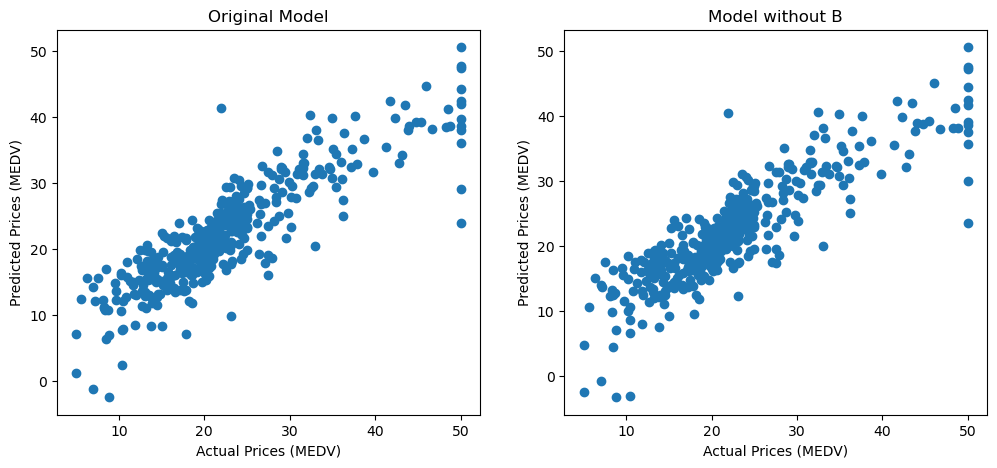

In [ ]:
X = boston_df.drop('MEDV', axis=1)
Y = boston_df['MEDV']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)


model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')




X_without_B = X.drop('B', axis=1)

X_train_without_B, X_test_without_B, Y_train, Y_test = train_test_split(X_without_B, Y, test_size=0.8, random_state=42)

model_without_B = LinearRegression()
model_without_B.fit(X_train_without_B, Y_train)
Y_pred_without_B = model_without_B.predict(X_test_without_B)
mse_without_B = mean_squared_error(Y_test, Y_pred_without_B)
r2_without_B = r2_score(Y_test, Y_pred_without_B)

print("\nModel without 'B'")
print(f'Mean Squared Error: {mse_without_B:.2f}')
print(f'R-squared: {r2_without_B:.2f}')




plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(Y_test, Y_pred)
plt.xlabel('Actual Prices (MEDV)')
plt.ylabel('Predicted Prices (MEDV)')
plt.title('Original Model')

plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_pred_without_B)
plt.xlabel('Actual Prices (MEDV)')
plt.ylabel('Predicted Prices (MEDV)')
plt.title('Model without B')

plt.show()

## Random forest regression

For comparison we also implement more complex random forest regression model, as our dataset contains a lot of variables with complex relationships. 

Best Hyperparameters: {'n_estimators': 94, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 11, 'max_depth': 15}
Mean Squared Error: 20.03
R-squared: 0.77


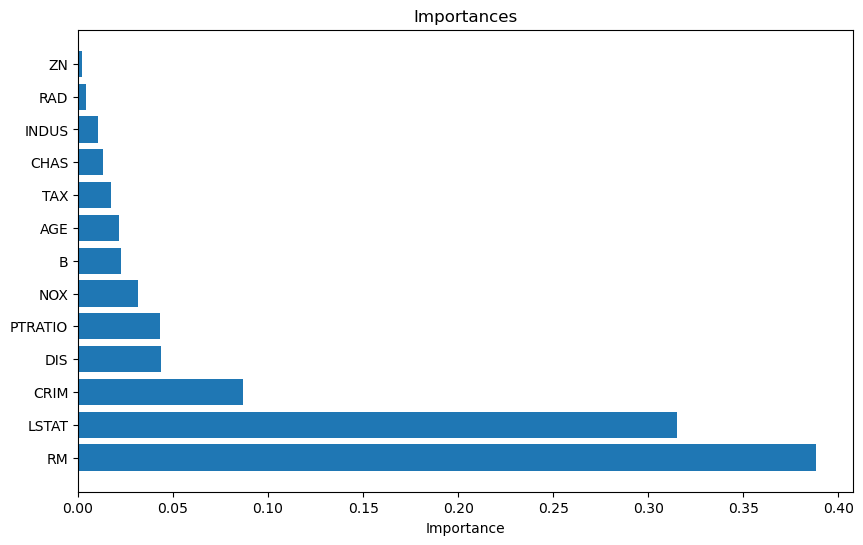

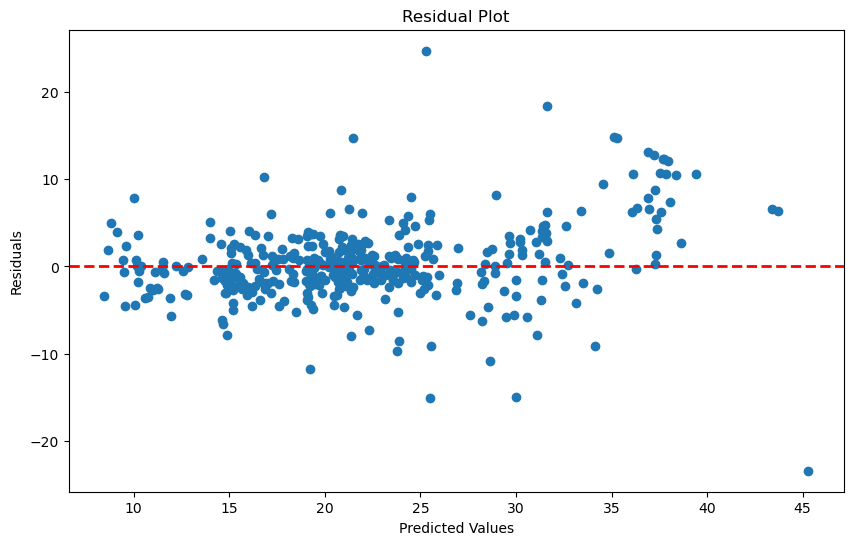

In [76]:


X = boston_df.drop('MEDV', axis=1)
Y = boston_df['MEDV']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

model_2 = RandomForestRegressor()
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=200, num=10)],
    'max_features': ['sqrt', 'log2', None] + list(range(1, X.shape[1] + 1)), 
    'max_depth': [int(x) for x in np.linspace(1, 20, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



random_search = RandomizedSearchCV(
    model_2,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    error_score='raise'
)
random_search.fit(X_train, Y_train)
params = random_search.best_params_
rf_model = RandomForestRegressor(**params)
rf_model.fit(X_train, Y_train)


Y_pred = rf_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')


importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Importances')
plt.show()

resid = Y_test - Y_pred

plt.figure(figsize=(10, 6))
plt.scatter(Y_pred, resid)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()



As highlited above, the LSTAT variable is given a significant role in the model and the dataset, further showing why the dataset is less appropriate for wider use. 

## Laso regression model

In [ ]:
# Laso regression with vs without B here

## Ridge regression model

TODO Collinearity?

In [ ]:
# Ridge regression with vs without B here